# LWEL Fabrication Camera Sequence
Code to analyse the image sequence during LWEL fabrication

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib import rcParams
import matplotlib.cm as cm
import math
import numpy as np
import pandas as pd
import os
import chart_studio.plotly as py
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.signal import savgol_filter
from mpl_toolkits import mplot3d
from pylab import *
from PIL import Image

%matplotlib inline

# specify sample path and export path
sample_folder = r'C:\Users\tl457\OneDrive - University Of Cambridge 1\1_Data\220225-LWEL-Fab\220225'
export_folder = r'C:\Users\tl457\OneDrive - University Of Cambridge 1\1_Data\220225-LWEL-Fab'

# specify matplotlib configuration file name
rc_fname = r'C:\Users\tl457\Documents\GitHub\spectroscopy\plotting_params.txt'

In [2]:
# specify filname prefix
fn_prefix='220225_Epoxide_2022-02-25-114524'

# find last image file with this prefix
n=0
while os.path.exists(os.path.join(sample_folder,fn_prefix+'-'+str(n).zfill(4)+'.png')):
    n=n+1 
end_suffix=n
print('Last file is '+fn_prefix+'-'+str(end_suffix-1).zfill(4)+'.png')

# create dictionary of images
images={}
for i in range (0,end_suffix):
    images[i]=Image.open(os.path.join(sample_folder,fn_prefix+'-'+str(i).zfill(4)+'.png'))
    
# create plotting arrays
time_id=np.linspace(0,end_suffix-1,end_suffix,dtype=int)
histogram_x=np.linspace(0,255,256,dtype=int)
    
# create list of colours for plots from list of samples
evenly_spaced_interval = np.linspace(0, 1, len(images))
colors = [cm.cividis(x) for x in evenly_spaced_interval]

print(images[0].mode,images[0].size)

Last file is 220225_Epoxide_2022-02-25-114524-0062.png
RGB (640, 480)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


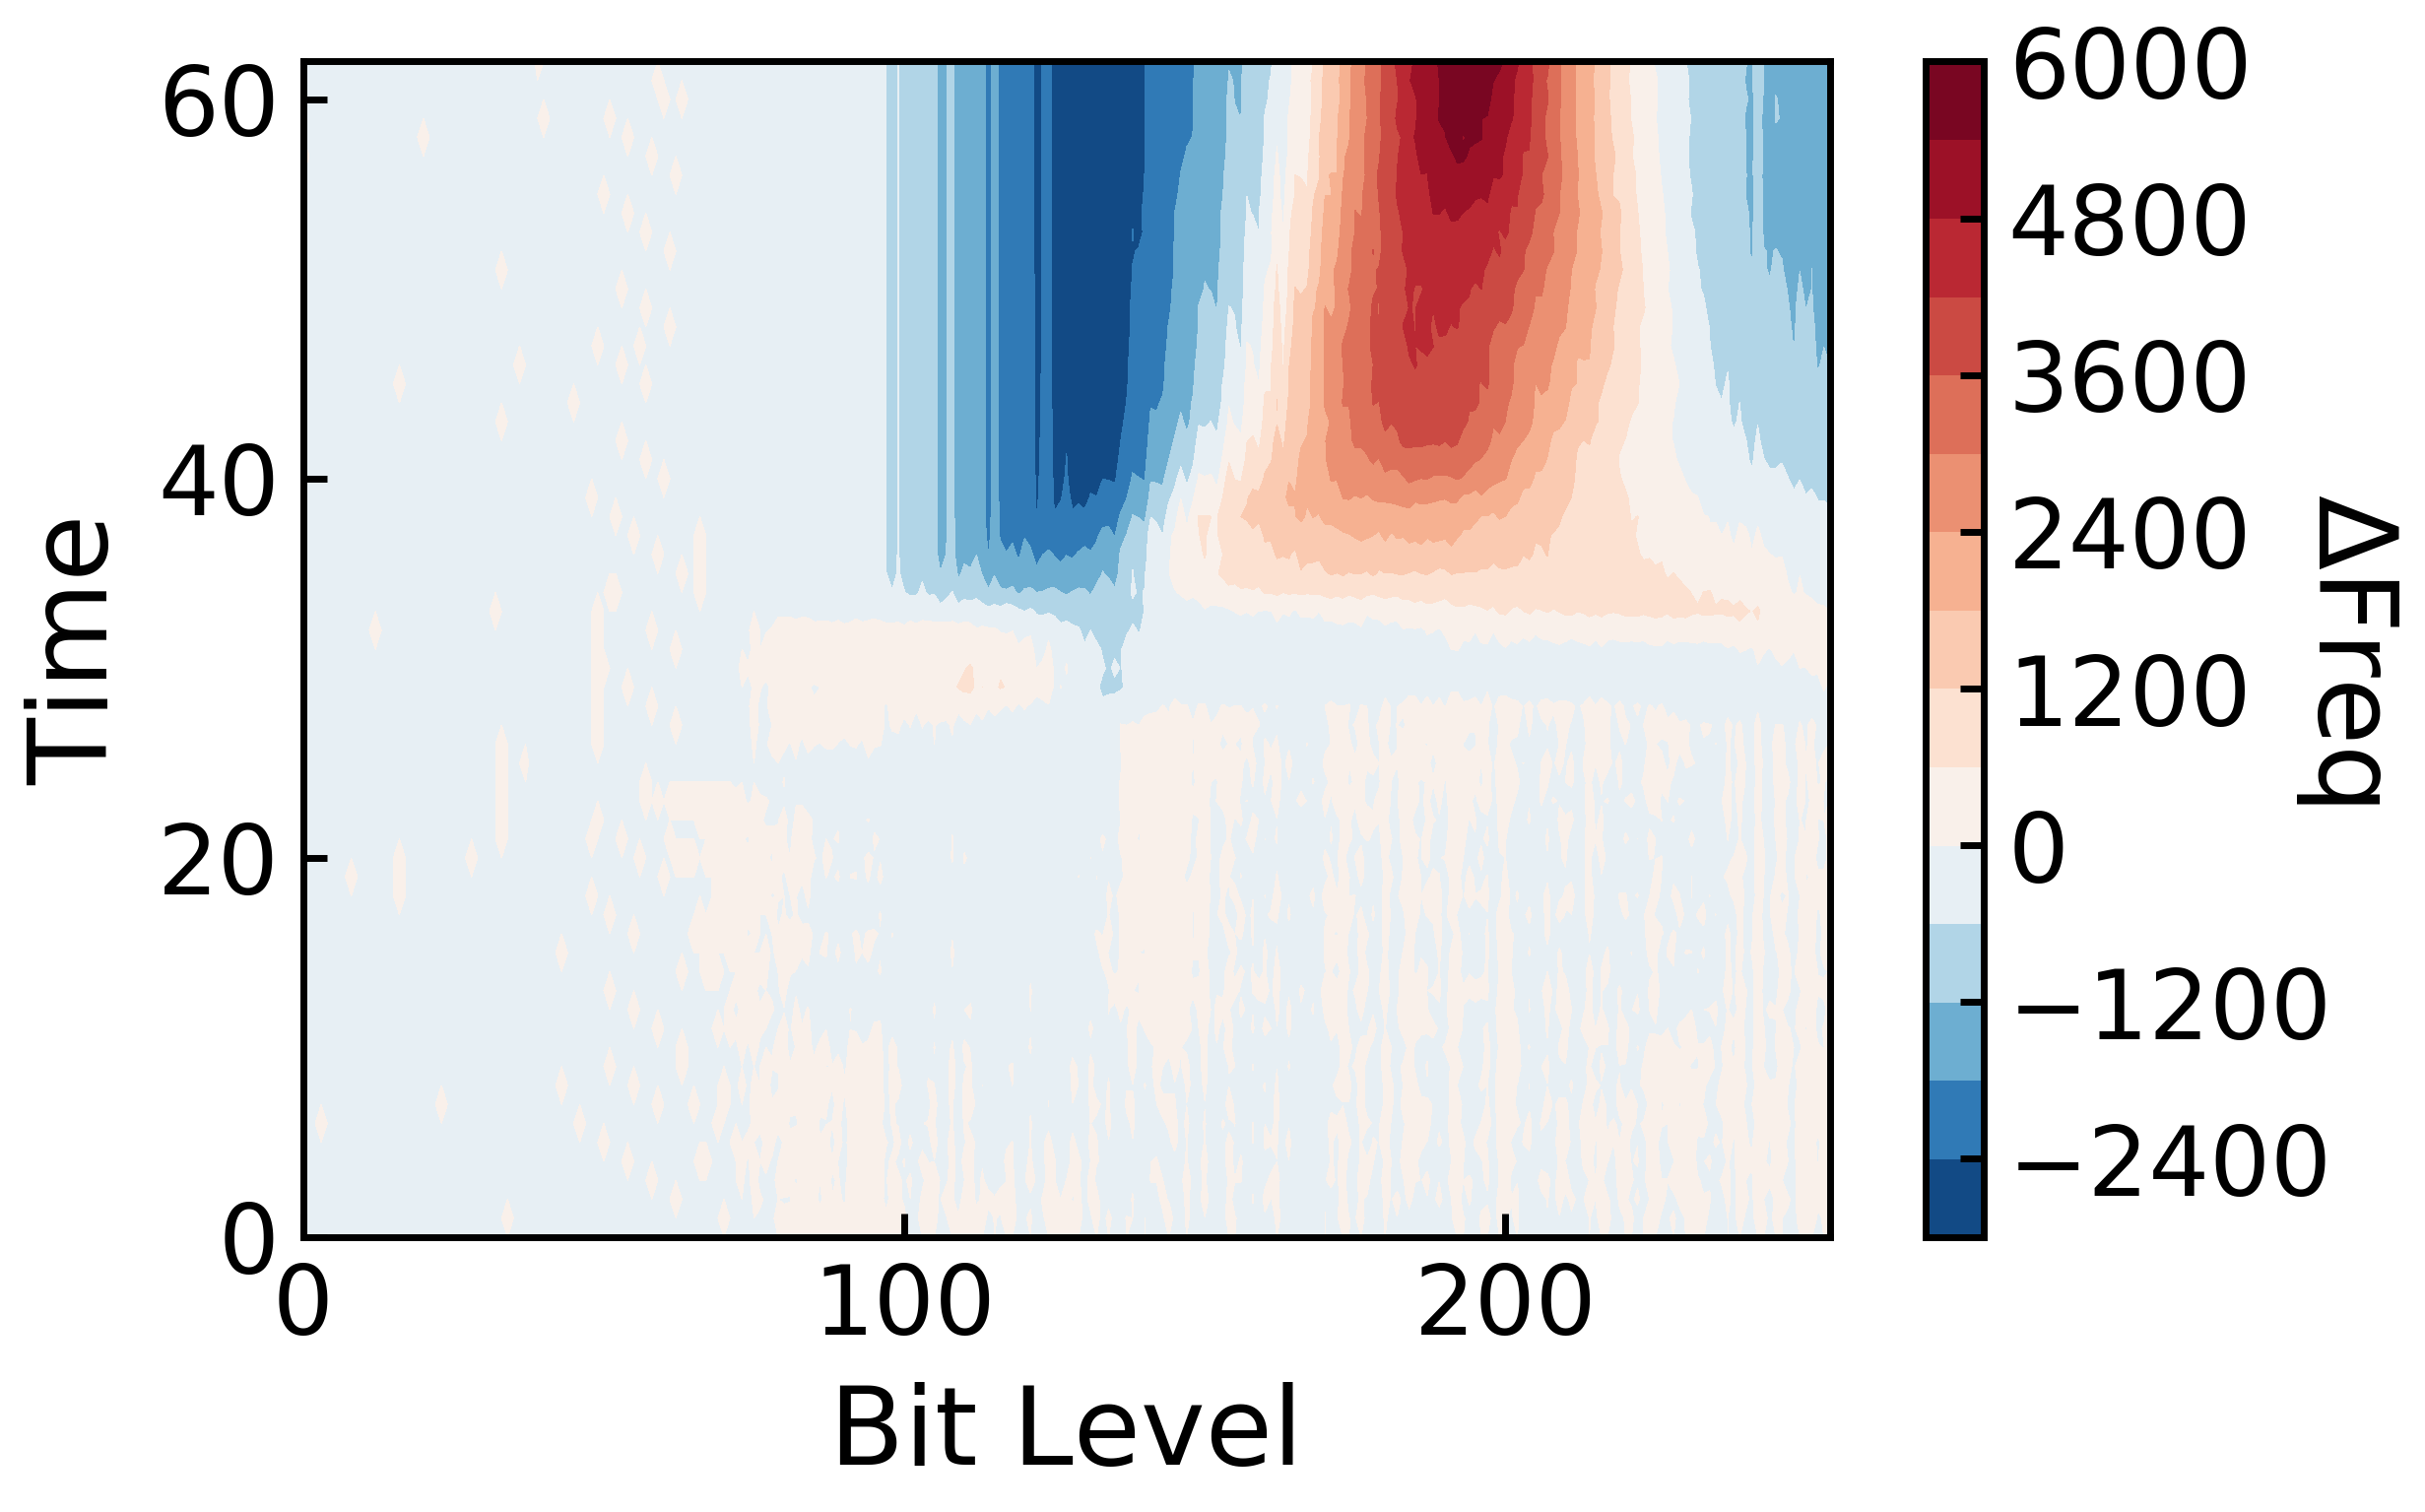

In [3]:
# generate 2D histogram (time vs counts)
arr_histogram=[]
for i in images:
    source= images[i].convert('L') # convert to monochrome
    arr_histogram.append(source.histogram())
df_histogram=pd.DataFrame(data=arr_histogram,index=time_id,columns=histogram_x)
df_histogram=df_histogram.drop(columns=255)
df_histogram_diff=df_histogram.sub(df_histogram.loc[0],axis='columns') # subtract first histogram from rest

# create levels and colourmap for the plot
min_freq=min(df_histogram_diff.min())
max_freq=max(df_histogram_diff.max())
levels = MaxNLocator(nbins=15).tick_values(min_freq,max_freq)
OD_n=int(np.floor((((max_freq-0)/(max_freq-min_freq))*256)))
OD_p=256-OD_n
cm_t=cm.get_cmap('RdBu', OD_p)
cm_b=cm.get_cmap('RdBu', OD_n)
newcolors=np.vstack((cm_t(np.linspace(1, 0.5, OD_p)),cm_b(np.linspace(0.5, 0, OD_n))))
newcmp=ListedColormap(newcolors, name='shifted_cmap')

# plot 2d histogram
with rc_context(fname=rc_fname):   
    cb=contourf(df_histogram_diff.columns, df_histogram_diff.index, df_histogram_diff, levels=levels,cmap=newcmp)
    xlabel("Bit Level")
    ylabel("Time")
    cbar=colorbar(cb)
    cbar.set_label('$\Delta$Freq', rotation=270,labelpad=10)
    plt.show()

Text(0.5, 0, '$\\Delta$Freq')

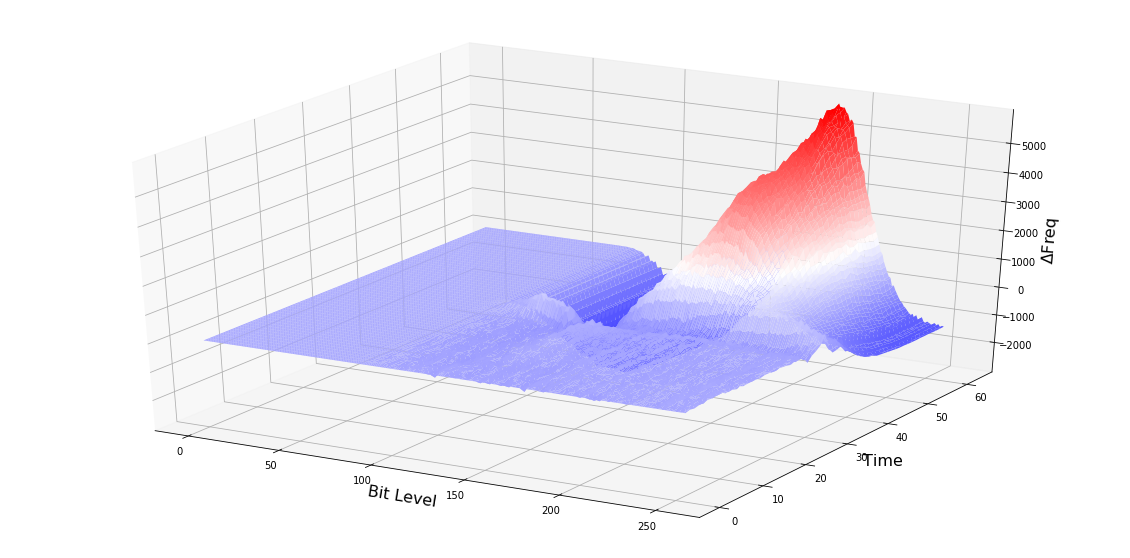

In [4]:
# create 3d histogram plot
X_1, Y_1 = np.meshgrid(df_histogram.columns,df_histogram.index)
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X_1, Y_1, df_histogram_diff, rstride=1, cstride=1,cmap='bwr', edgecolor='none')
ax.set_xlabel('Bit Level',fontsize=16)
ax.set_ylabel('Time',fontsize=16)
ax.set_zlabel('$\Delta$Freq',fontsize=16)

In [5]:
# fourier transform images
images_fft={}
for i in images:
    temp=np.asarray(images[i].convert('L')) # convert to monochrome
    ft_image=np.fft.fftshift(np.fft.fft2(temp))
    images_fft[i]=ft_image

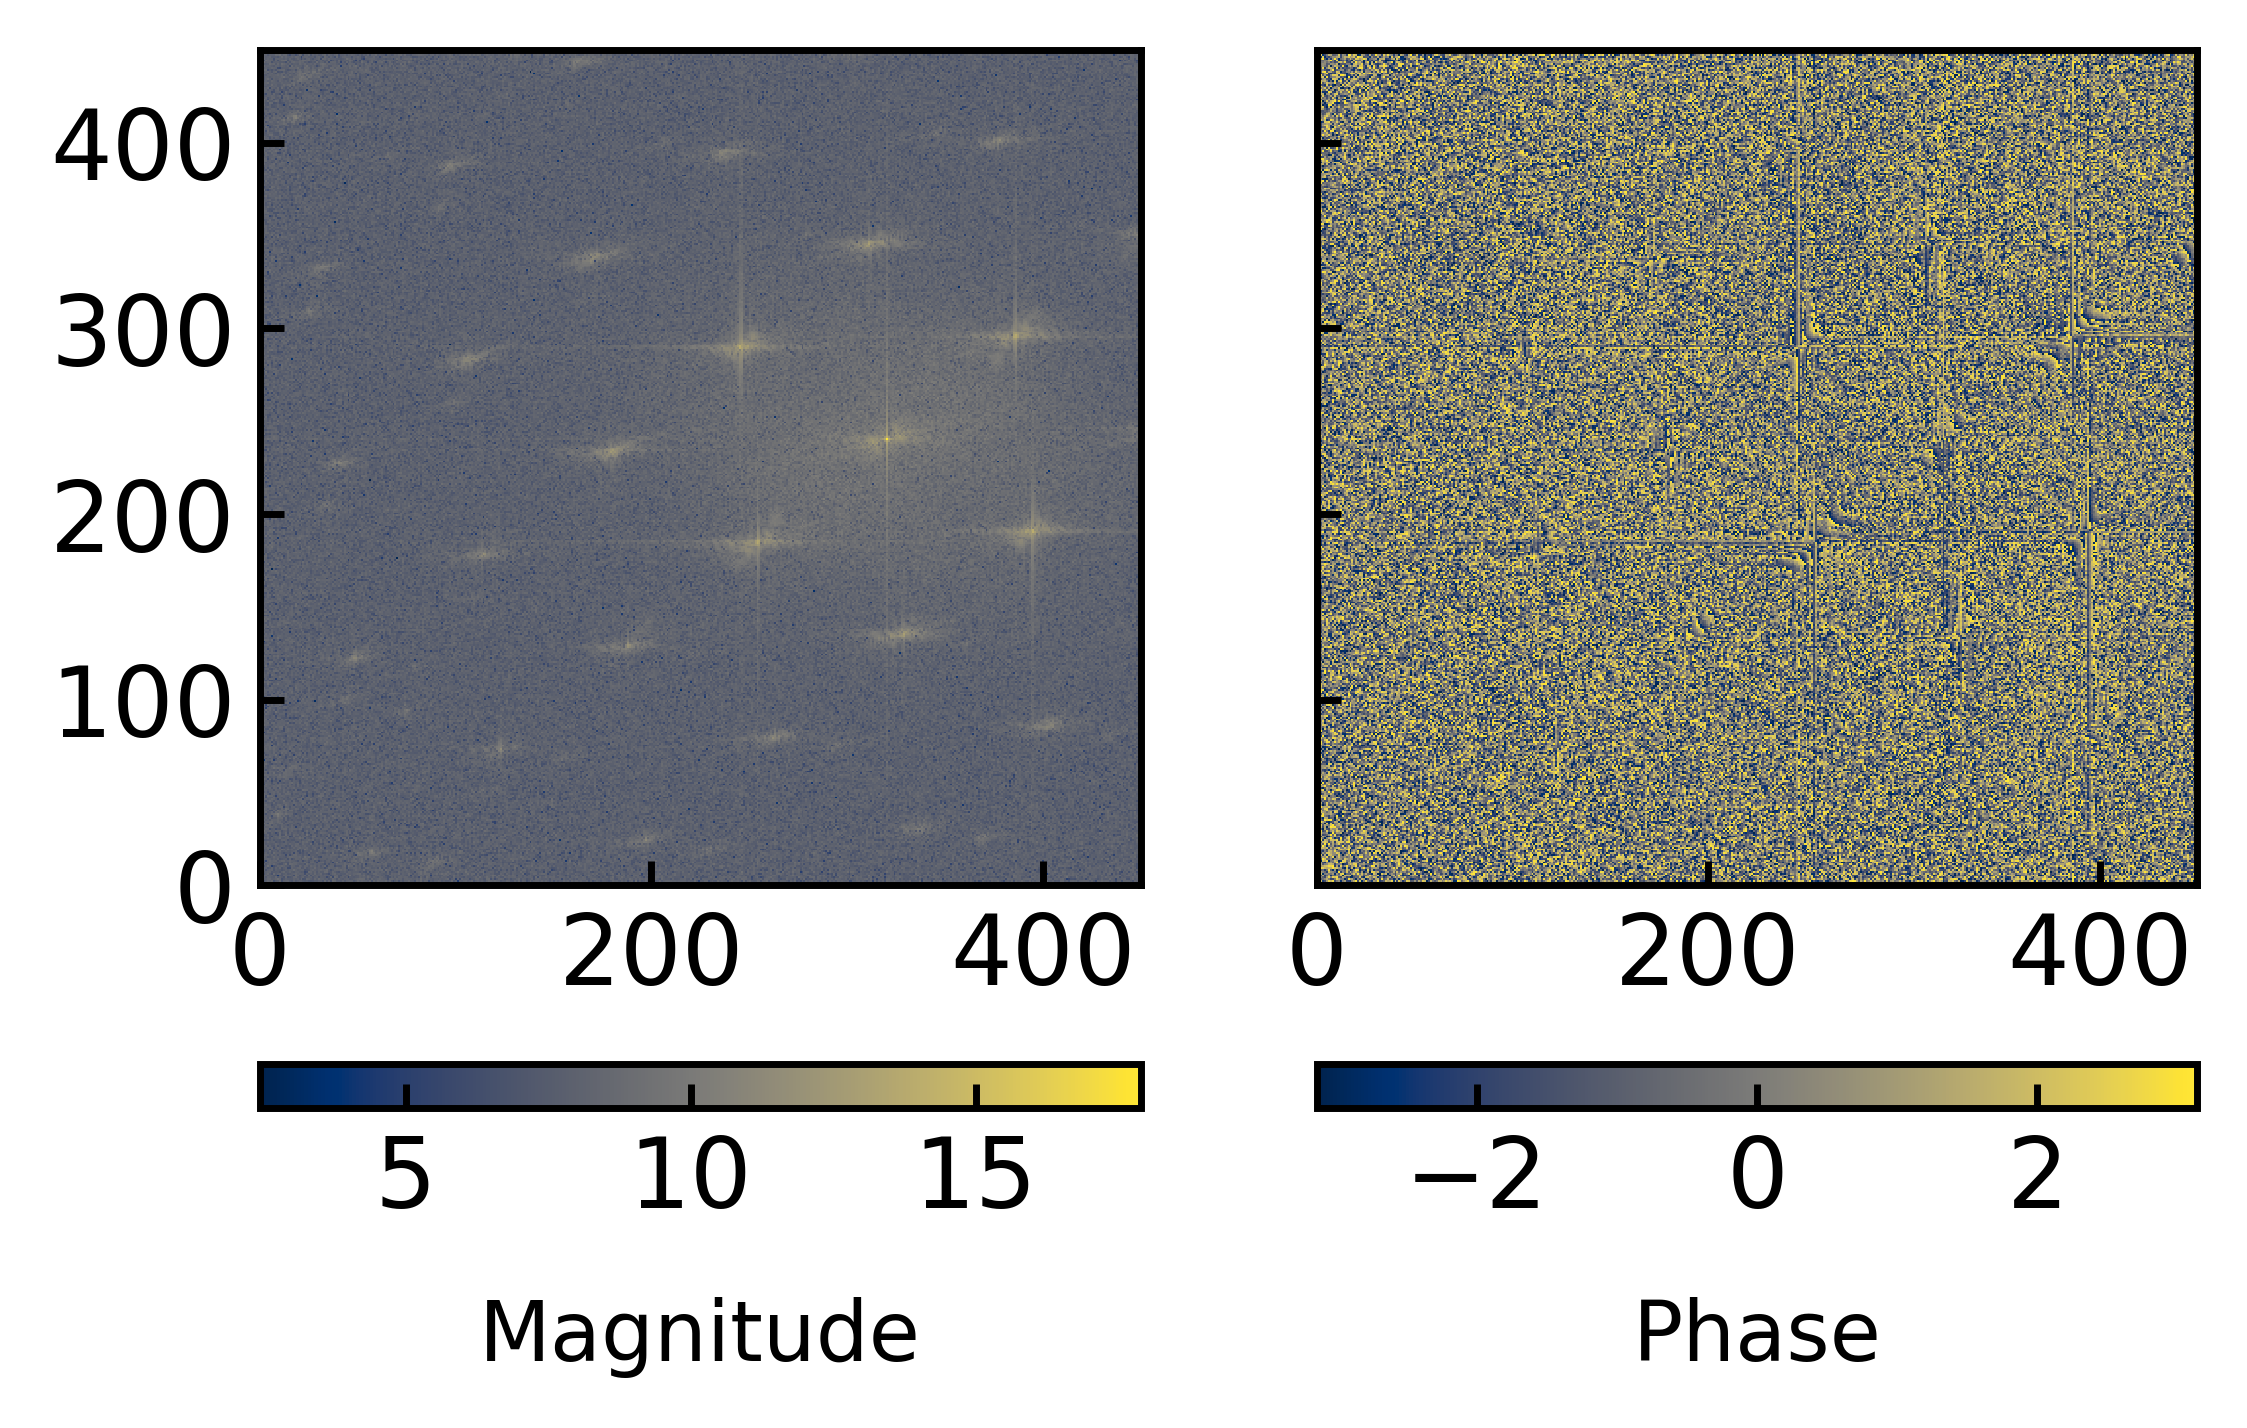

In [6]:
plot_index=55
with rc_context(fname=rc_fname):
    fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True)
    cb1=ax1.pcolormesh(np.log(np.abs(images_fft[plot_index])),cmap='cividis')
    cbar1=colorbar(cb1,ax=ax1,orientation='horizontal')
    cbar1.set_label('Magnitude',labelpad=10,fontsize=12)
    ax1.set_xlim(0,450)
    ax1.set_ylim(0,450)
    cb2=ax2.pcolormesh(np.angle(images_fft[plot_index],deg=False),cmap='cividis')
    cbar2=colorbar(cb2,ax=ax2,orientation='horizontal')
    cbar2.set_label('Phase',labelpad=10,fontsize=12)
    ax2.set_xlim(0,450)

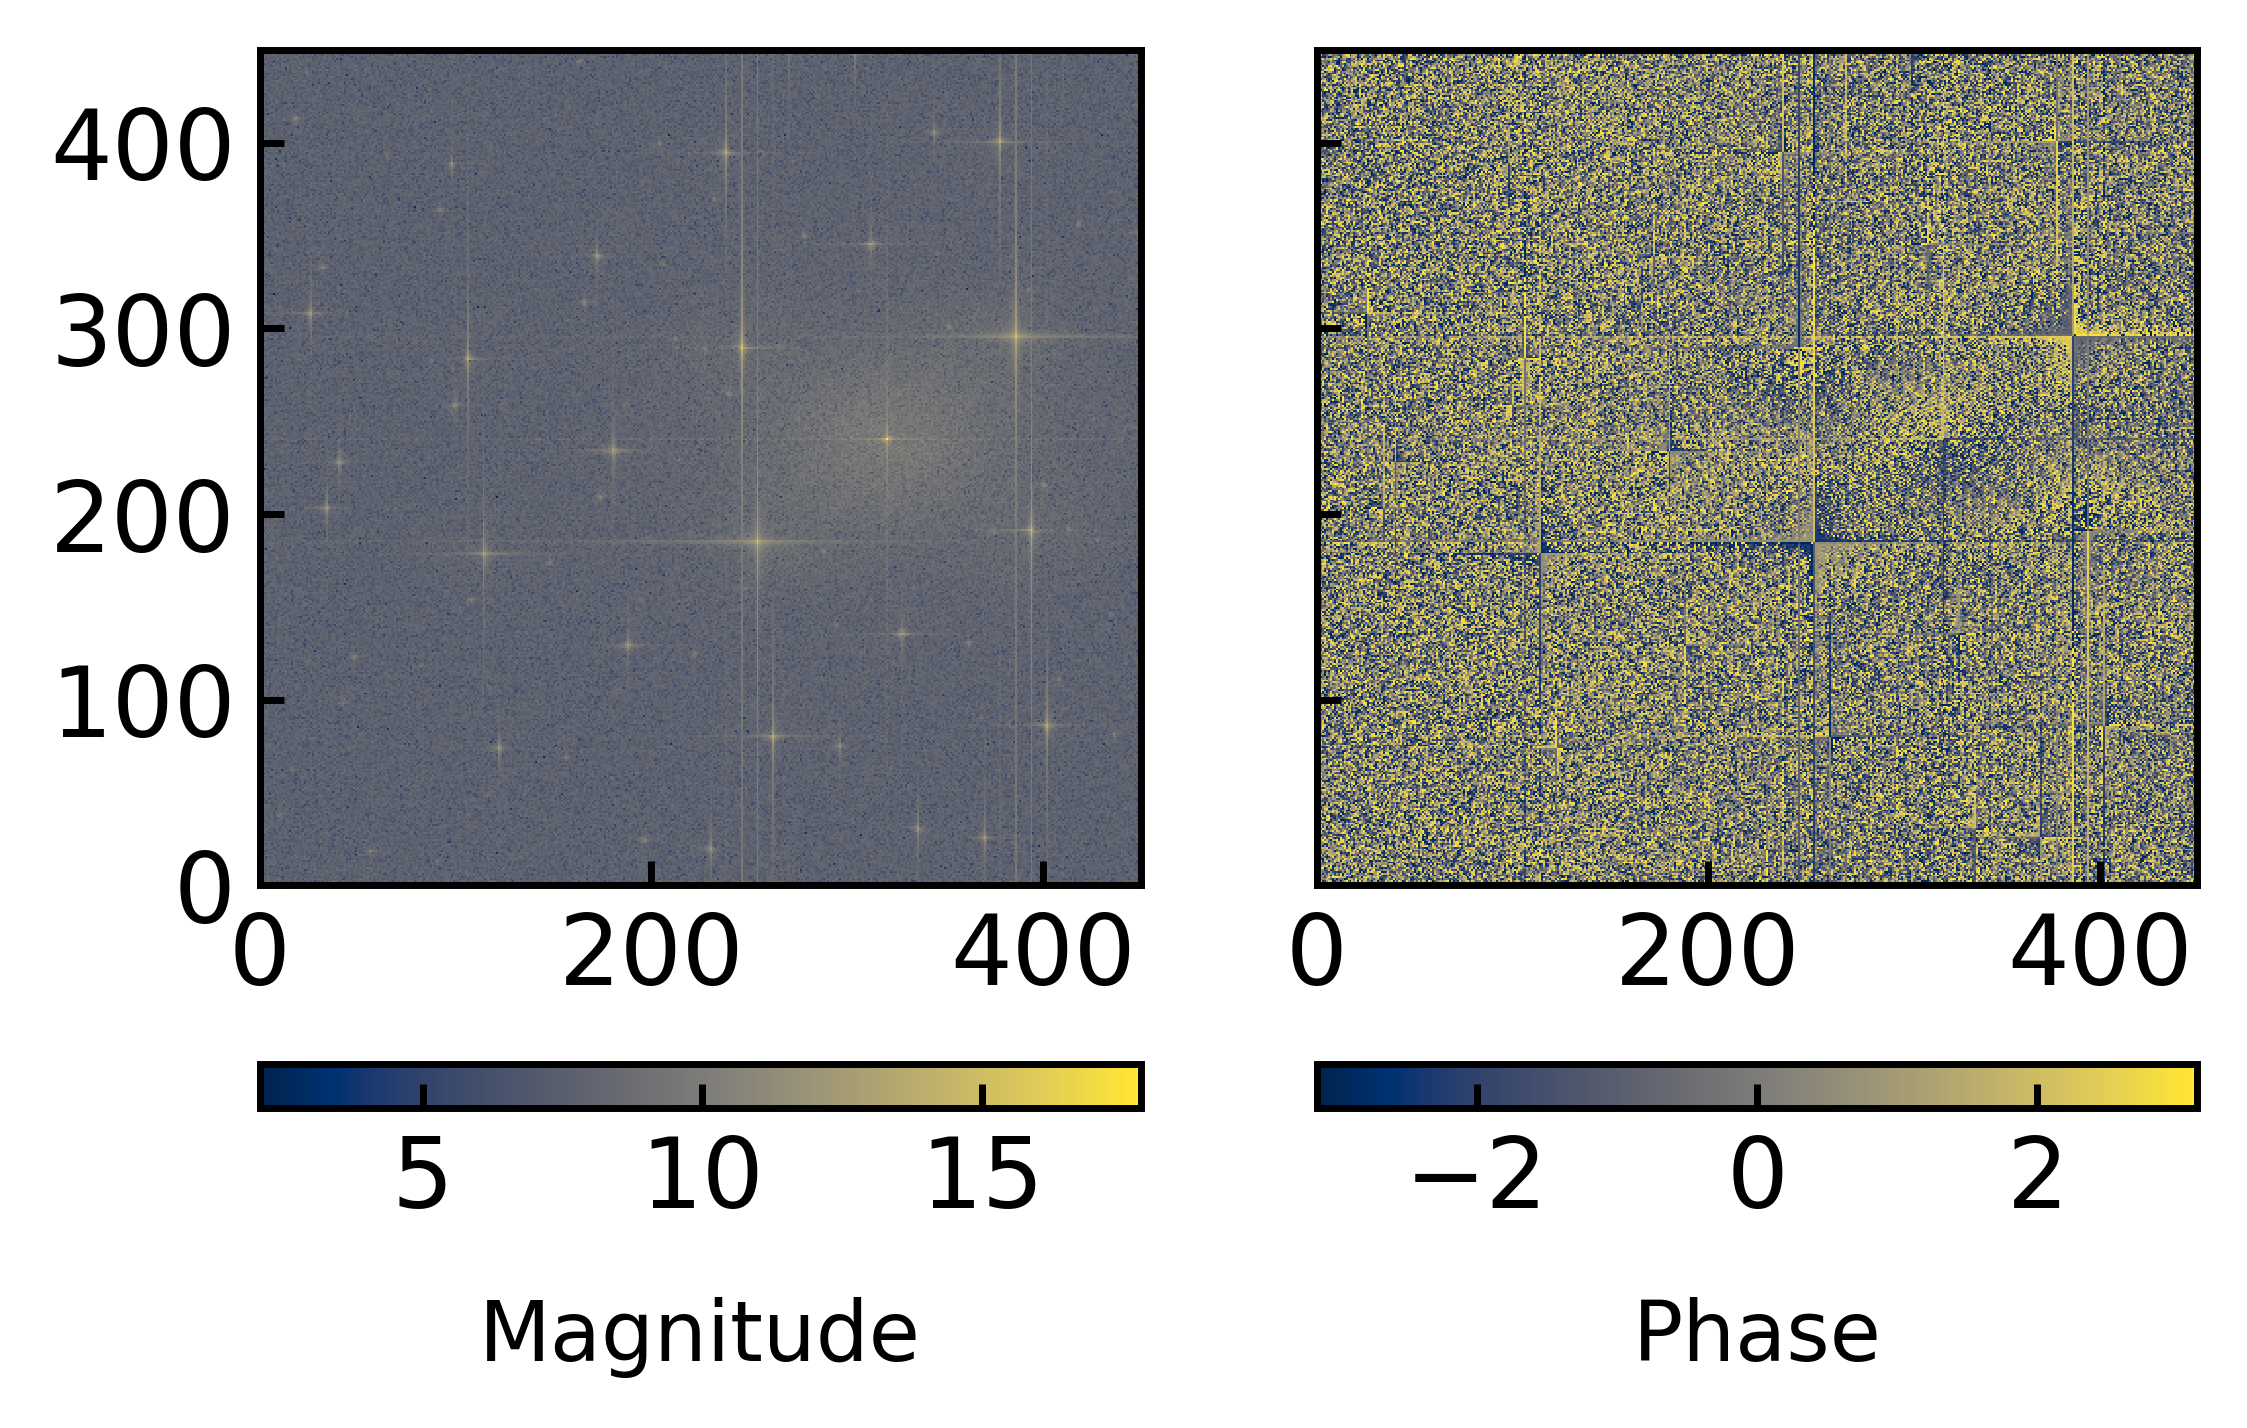

In [7]:
plot_index=1
with rc_context(fname=rc_fname):
    fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True)
    cb1=ax1.pcolormesh(np.log(np.abs(images_fft[plot_index])),cmap='cividis')
    cbar1=colorbar(cb1,ax=ax1,orientation='horizontal')
    cbar1.set_label('Magnitude',labelpad=10,fontsize=12)
    ax1.set_xlim(0,450)
    ax1.set_ylim(0,450)
    cb2=ax2.pcolormesh(np.angle(images_fft[plot_index],deg=False),cmap='cividis')
    cbar2=colorbar(cb2,ax=ax2,orientation='horizontal')
    cbar2.set_label('Phase',labelpad=10,fontsize=12)
    ax2.set_xlim(0,450)

In [8]:
# export videos
gif_real = []
for i in images:
    gif_real.append(images[i])
gif_real[0].save(os.path.join(export_folder,fn_prefix+'.gif'),save_all=True, append_images=gif_real[1:])